### -- Next --
* tune changepoint_prior_scale (k)
    * Typical Values: 0.001 to 0.5
* tune seasonality_prior_scale ()
    * Typical Values: 0.1 to 10
* tune fourier_order ()
    * Typical Values: 3 to 10 (for yearly seasonality)
* n_changepoints ()
    *  Typical Values: 20-50 for typical time series

Plan:
* Start with a reasonable set of default values for all hyperparameters.
* Tune one parameter at a time while keeping others constant to understand its individual impact.
* Use a grid search or other hyperparameter tuning techniques to systematically explore the parameter space.
* Visualize the forecasts to assess the model's fit and identify areas for improvement.
* Iteratively refine your hyperparameter choices based on the results of your experiments.

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from datetime import date

In [3]:
st = st.Stocks()

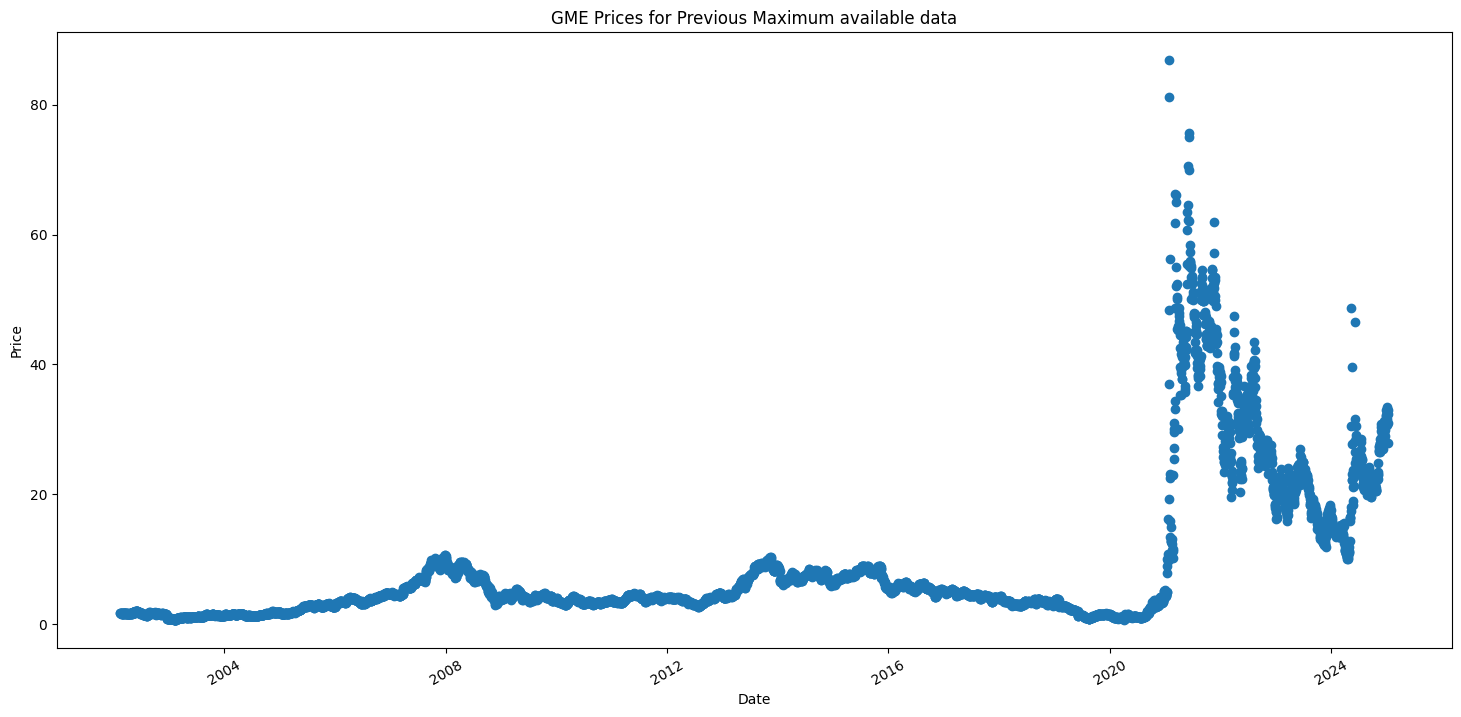

Closing price as of 2025-01-14: $27.88
The percentage change over previous Maximum available data is 1621%
Dividends total $2.39
Stock Splits total $6.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('gme')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716073,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683251,1.687459,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615920,1.662210,1.603296,1.662210,6892800,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head() # making sure dynamic_winsorize() worked

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
32,2002-04-02,1.599088,1.599088,1.544382,1.568789,2098400,0.0,0.0,1.571062,1.77604,1.571062
33,2002-04-03,1.569631,1.582255,1.551957,1.565423,567200,0.0,0.0,1.566938,1.77604,1.566938
35,2002-04-05,1.594880,1.632753,1.556165,1.556165,837600,0.0,0.0,1.560331,1.77604,1.560331
36,2002-04-08,1.565423,1.565423,1.495568,1.540174,1558400,0.0,0.0,1.547370,1.77604,1.547370
40,2002-04-12,1.569631,1.569631,1.519975,1.535966,1236000,0.0,0.0,1.537860,1.77604,1.537860


In [9]:
# format new dataset for model with 'ds' and 'y' for prophet model

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [10]:
# set training period
train_period = 365 * 4
df_train = df_train[-train_period:] 

# set forecast period
predict_period = 365

In [11]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_overall_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-predict_period:]
    y_pred = forecast['yhat'][-predict_period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [12]:
# create baseline model

m1 = Prophet()
m1.fit(df_train)

16:11:18 - cmdstanpy - INFO - Chain [1] start processing
16:11:18 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# create cross_validation function for reusability

def cv_func(model_name):
    return cross_validation(model_name, initial=f'{train_period} days', period='365 days', horizon = '365 days')

In [14]:
%%time

# create baseline model

m1 = Prophet()
m1.fit(df_train)

# Get cv metrics
df_cv = cv_func(m1)
df_p = performance_metrics(df_cv)
print(pd.DataFrame(df_p.mean()).T)
period = predict_period

future = m1.make_future_dataframe(periods=period)
forecast = m1.predict(future)

get_overall_accuracy(df_train.Close, forecast)

16:11:18 - cmdstanpy - INFO - Chain [1] start processing
16:11:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:11:18 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] done processing


                       horizon        mse       rmse        mae      mape  \
0  198 days 14:35:25.110132158  184.03626  11.978132  11.608311  0.504417   

      mdape     smape  coverage  
0  0.508961  0.726435  0.356828  
CPU times: user 299 ms, sys: 54.1 ms, total: 354 ms
Wall time: 760 ms


,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,12.886332,0.792494,199.459949,14.123029


In [15]:
# # get interactive visual

# # Plot Forecast
fig1 = plot_plotly(m1, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price', 
                   xaxis_title='Date',
                   width=1500
                   )
# # Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### -- Set Parameters to None --

In [16]:
params = {
    'best_changepoint_prior_scale_score': float('inf'), # update this dict and functions to reflect this
    'best_changepoint_prior_scale': None,
    'best_sps_fourier_score': float('inf'), 
    'best_seasonality_prior_scale': None, 
    'best_n_changepoints_score': float('inf'),
    'best_n_changepoints': None,
    'best_fourier_order': None,
    'best_cv_metrics': None, 
    'overall_accuracy': None
          }

### -- Tune Changepoint --

In [17]:
def tune_changepoint(
        best_changepoint_prior_scale_score,
        best_changepoint_prior_scale,
        best_sps_fourier_score,
        best_seasonality_prior_scale,
        best_n_changepoints_score,	
        best_n_changepoints,
        best_fourier_order,
        best_cv_metrics,
        overall_accuracy
        ):

# ideal changepoints are random, not clustered, so flushing out the perfect changepoint is not done by applying evenly spaced numbers in cpv's.
# instead I use a log range, which includes a wider range of values in the optimal area, which is between 0 and 1.
 
    cps_range=(-3, 1)
    num_points=10
    refinement_steps=2
    refinement_factor=0.1
    best_score = float('inf')

    for i in range(refinement_steps + 1):
        if i > 1:
            # Refine the search range around the best value
            range_width = cps_range[1] - cps_range[0]
            cps_range = (np.log10(current_best_changepoint_prior_scale) - range_width * refinement_factor, 
                            np.log10(current_best_changepoint_prior_scale) + range_width * refinement_factor)
        changepoint_prior_scale_values = np.logspace(cps_range[0], cps_range[1], num_points) 

        for cps in changepoint_prior_scale_values:
            if best_seasonality_prior_scale is None: # if this is first iteration, don't include hyperparameters
                m = Prophet(changepoint_prior_scale=cps)
            else: # if not first iteration, include all adjusted hyperparameters
                m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                    seasonality_prior_scale=best_seasonality_prior_scale,
                    n_changepoints=best_n_changepoints)
                m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)
            m.fit(df_train)
            df_cv = cv_func(m)
            df_p = performance_metrics(df_cv)
            score = df_p['rmse'].mean() 

            if score < best_score:
                best_score = score # save best score
                current_best_changepoint_prior_scale = cps # save best changepoint
                best_cv_metrics = pd.DataFrame(df_p.mean()).T # save best cross-validation metrics
        
    # save best overall metrics
    if best_changepoint_prior_scale_score > best_score:
        best_changepoint_prior_scale_score = best_score
        best_changepoint_prior_scale = current_best_changepoint_prior_scale
        if best_seasonality_prior_scale is None: # if this is first iteration, don't include other hyperparameters
            m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale)
        else: # if not first iteration, include all adjusted hyperparameters
            m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                seasonality_prior_scale=best_seasonality_prior_scale,
                n_changepoints=best_n_changepoints)
            m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)
    else:
        m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
            seasonality_prior_scale=best_seasonality_prior_scale,
            n_changepoints=best_n_changepoints)
        m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)

    m.fit(df_train)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    overall_accuracy = get_overall_accuracy(df_train.Close, forecast)
    print(overall_accuracy) # in app, have metrics df update with each iteration
    print(best_cv_metrics)

    params = {
    'best_changepoint_prior_scale_score': best_changepoint_prior_scale_score,
    'best_changepoint_prior_scale': best_changepoint_prior_scale,
    'best_cv_metrics': best_cv_metrics, 
    'overall_accuracy': overall_accuracy
          }

    return params

### -- Tune Seasonality & Fourier Order --

In [18]:
def tune_seasonality_fourier_order(
        best_changepoint_prior_scale_score,
        best_changepoint_prior_scale,
        best_sps_fourier_score,
        best_seasonality_prior_scale,
        best_n_changepoints_score,	
        best_n_changepoints,
        best_fourier_order,
        best_cv_metrics,
        overall_accuracy
        ):
    
    sps_range = (-2, 2)
    fo_start, fo_end = (2, 10)
    num_points = 15
    refinement_steps = 2
    refinement_factor = 0.1
    best_score = float('inf')

    for i in range(refinement_steps + 1):
        # refine sps range
        if i > 1:
            range_width = sps_range[1] - sps_range[0]
            sps_range = (np.log10(current_best_seasonality_prior_scale) - range_width * refinement_factor, 
                            np.log10(current_best_seasonality_prior_scale) + range_width * refinement_factor)
        # refine fo range
            if current_best_fourier_order < 4:
                fo_start = 1
                fo_end = 7
            elif current_best_fourier_order > 7:
                fo_start = 3
                fo_end = 11
            else:
                fo_start = max(1, current_best_fourier_order - 2) 
                fo_end = min(10, current_best_fourier_order + 2) 
        # set sps & fo ranges
        seasonality_prior_scale_values = np.logspace(sps_range[0], sps_range[1], num_points) 
        fourier_order_values = np.arange(fo_start, fo_end)

        for sps in seasonality_prior_scale_values:
            for fo in fourier_order_values:
                if best_n_changepoints is None: # if this is first iteration, don't include hyperparameters
                    m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                                seasonality_prior_scale=sps) 
                    m.add_seasonality(name='yearly', period=365.25, fourier_order=fo)  
                else: # if not first iteration, include all adjusted hyperparameters
                    m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                        seasonality_prior_scale=sps,
                        n_changepoints=best_n_changepoints)
                    m.add_seasonality(name='yearly', period=365.25, fourier_order=fo)
            m.fit(df_train)
            df_cv = cv_func(m)
            df_p = performance_metrics(df_cv)
            score = df_p['rmse'].mean() 

        if score < best_score:
            best_score = score # save best score for function eval
            current_best_seasonality_prior_scale = sps
            current_best_fourier_order = fo
            best_cv_metrics = pd.DataFrame(df_p.mean()).T # save best cross-validation metrics


    # save best overall metrics
    if best_sps_fourier_score > best_score:
        best_sps_fourier_score = best_score
        best_seasonality_prior_scale, best_fourier_order = current_best_seasonality_prior_scale, current_best_fourier_order
        if best_n_changepoints is None: # if this is first iteration, don't include other hyperparameters
            m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                        seasonality_prior_scale=best_seasonality_prior_scale)
            m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)    
        else: # if not first iteration, include all adjusted hyperparameters
            m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                seasonality_prior_scale=best_seasonality_prior_scale,
                n_changepoints=best_n_changepoints)
            m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)
    else:
        m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
            seasonality_prior_scale=best_seasonality_prior_scale,
            n_changepoints=best_n_changepoints)
        m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)

    m.fit(df_train)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    overall_accuracy = get_overall_accuracy(df_train.Close, forecast)
    print(overall_accuracy)
    print(best_cv_metrics)

    params = {
    'best_seasonality_prior_scale': best_seasonality_prior_scale,
    'best_sps_fourier_score': best_sps_fourier_score,
    'best_fourier_order': best_fourier_order,
    'best_cv_metrics': best_cv_metrics, 
    'overall_accuracy': overall_accuracy
          }

    return params

### -- Tune Number of Changepoints --

In [19]:
def tune_n_changepoints(
        best_changepoint_prior_scale_score,
        best_changepoint_prior_scale,
        best_sps_fourier_score,
        best_seasonality_prior_scale,
        best_n_changepoints_score,	
        best_n_changepoints,
        best_fourier_order,
        best_cv_metrics,
        overall_accuracy
        ):
    
    ncp_start, ncp_end = (20, 51)
    refinement_steps = 3
    best_score = float('inf')

    # refine ncp range
    for i in range(refinement_steps + 1):
        if i > 0:
            if current_best_n_changepoints < 25:
                ncp_start, ncp_end = (15, 35)
            elif current_best_n_changepoints > 45:
                ncp_start, ncp_end = (35, 55)
            else:
                ncp_start = max(1, current_best_n_changepoints - 5) 
                ncp_end = min(100, current_best_n_changepoints + 2) 
        # set ncp range
        n_changepoints_values = np.arange(ncp_start, ncp_end, 2)

        for ncp in n_changepoints_values:
            m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                        seasonality_prior_scale=best_seasonality_prior_scale,
                        n_changepoints=ncp) 
            m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)
            m.fit(df_train)
            df_cv = cv_func(m)
            df_p = performance_metrics(df_cv)
            score = df_p['rmse'].mean() 

            if score < best_score:
                best_score = score # save best score
                current_best_n_changepoints = ncp # save best n_changepoints
                best_cv_metrics = pd.DataFrame(df_p.mean()).T # save best cross-validation metrics

    # save best overall metrics
    if best_n_changepoints_score > best_score:
        best_n_changepoints_score = best_score
        best_n_changepoints = current_best_n_changepoints

    m = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                seasonality_prior_scale=best_seasonality_prior_scale,
                n_changepoints=best_n_changepoints) 
    m.add_seasonality(name='yearly', period=365.25, fourier_order=best_fourier_order)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    overall_accuracy = get_overall_accuracy(df_train.Close, forecast)
    print(overall_accuracy)
    print(best_cv_metrics)

    params = {
        'best_n_changepoints_score': best_n_changepoints_score,
        'best_n_changepoints': best_n_changepoints,
        'best_cv_metrics': best_cv_metrics,
        'overall_accuracy': overall_accuracy
    }

    return params

### -- Iteration --

In [20]:
def tune_hyperparameters(
                params=params,
                n_iterations=3
                ):
        
        tuning_results = {}

        for loop in range(n_iterations):
                params.update(tune_changepoint(**params))
                params.update(tune_seasonality_fourier_order(**params))
                params.update(tune_n_changepoints(**params))
    
    # to observe the hyperparameter values before the final product, i have indented the below code
                m = Prophet(changepoint_prior_scale=params['best_changepoint_prior_scale'],
                                seasonality_prior_scale=params['best_seasonality_prior_scale'],
                                n_changepoints=params['best_n_changepoints'])
                m.add_seasonality(name='yearly', period=365.25, fourier_order=params['best_fourier_order'])
                m.fit(df_train)
                future = m.make_future_dataframe(periods=predict_period)
                forecast = m.predict(future)

                tuning_results[f'Overall accuracy {loop}'] = None 
                tuning_results[f'Cv Metrics {loop}'] = None 

                tuning_results[f'Overall accuracy {loop}'],
                tuning_results[f'Cv Metrics {loop}'] \
                = params['overall_accuracy'], 
                params['best_cv_metrics']



        print(params['overall_accuracy'])
        print(params['best_cv_metrics'])
        
        return m, forecast, tuning_results

In [22]:
%%time

m2, forecast, tuning_results = tune_hyperparameters()

16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing
16:27:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:27:10 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [ ]:
tuning_key_list = tuning_results.keys()

In [ ]:
for i in tuning_key_list:
    print(tuning_results[i])

In [ ]:
# get interactive visual

# Plot Forecast
fig1 = plot_plotly(m2, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price', 
                   xaxis_title='Date',
                   width=1500
                   )
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

In [ ]:
pd.DataFrame(params['best_cv_metrics'])

In [ ]:
pd.DataFrame(params['overall_accuracy'])

### -- To Do --
- Compare forecast to actuals. which model performed better?
- understand the error when fitting the model. what is it? does it affect your ability to tune the model?
- instead of continuing to try to adjust your processes, let's focus on completing the project. 
    - showing that you don't like to simply accept results is a good thing, even if you can't do it better. have it be a talking point. 
    - also, don't forget to compare your forecasted datasets. 

- did winsorizing help th prophet model? compare cross validation scores on these for a model w and wo optimization. 
    - it performs slightly better on standard mape (not cv mape). 
    - what other cleaning / prep / feature engineering can I perform on the data to get a better understanding and get a better model? any inferences should get pushed to the KPI bar
    - have outliers be talking point. winsor handles that
    - any other weird shit i can id in analysis?

- Include Priya's method of hyperparameter tuning using best rmse scores and plugging it into the model to get best score. 

https://www.youtube.com/watch?v=hht0iKzviWE&list=PLwzgGZH80kOUa7kMhzcMYaWPk0iFeLXon&index=21

- Move indicators to final visual: bollingers, etc